### Marketing Analytics Customer Segmentation Project

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [ ]:
! pip install gower

  Created wheel for gower: filename=gower-0.0.5-cp37-none-any.whl size=4232 sha256=1fde6e94f9ee5f83603d061a7a71b5709e71313e40993fd38014ea1733d890c1
  Stored in directory: /root/.cache/pip/wheels/c0/09/9b/072d54d6ced0f43a179852e3f09532d0131e25ff7cb4e5ee75
Successfully built gower


In [ ]:
import gower
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist, squareform
from sklearn import metrics 

In [ ]:
# connecting to google drive
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
# import our data file from shared drive
path = '/content/drive/Shareddrives/BA820/marketing_data.csv'
marketing = pd.read_csv(path)

# Data Cleaning

In [ ]:
marketing.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country
0,1826,1970,Graduation,Divorced,"$84,835.00",0,0,6/16/2014,0,189,104,379,111,189,218,1,4,4,6,1,0,0,0,0,0,1,0,SP
1,1,1961,Graduation,Single,"$57,091.00",0,0,6/15/2014,0,464,5,64,7,0,37,1,7,3,7,5,0,0,0,0,1,1,0,CA
2,10476,1958,Graduation,Married,"$67,267.00",0,1,5/13/2014,0,134,11,59,15,2,30,1,3,2,5,2,0,0,0,0,0,0,0,US
3,1386,1967,Graduation,Together,"$32,474.00",1,1,5/11/2014,0,10,0,1,0,0,0,1,1,0,2,7,0,0,0,0,0,0,0,AUS
4,5371,1989,Graduation,Single,"$21,474.00",1,0,4/8/2014,0,6,16,24,11,0,34,2,3,1,2,7,1,0,0,0,0,1,0,SP


In [ ]:
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   2240 non-null   int64 
 1   Year_Birth           2240 non-null   int64 
 2   Education            2240 non-null   object
 3   Marital_Status       2240 non-null   object
 4   Income               2216 non-null   object
 5   Kidhome              2240 non-null   int64 
 6   Teenhome             2240 non-null   int64 
 7   Dt_Customer          2240 non-null   object
 8   Recency              2240 non-null   int64 
 9   MntWines             2240 non-null   int64 
 10  MntFruits            2240 non-null   int64 
 11  MntMeatProducts      2240 non-null   int64 
 12  MntFishProducts      2240 non-null   int64 
 13  MntSweetProducts     2240 non-null   int64 
 14  MntGoldProds         2240 non-null   int64 
 15  NumDealsPurchases    2240 non-null   int64 
 16  NumWeb

In [ ]:
# dropping ID column since it has no predictive power
marketing = marketing.drop(['ID', 'Response'], axis=1)

In [ ]:
# dropping rows where income is null
marketing = marketing.dropna()

In [ ]:
# creating a column for total amount spent in past 2 years
marketing['TotalMntSpent'] = marketing['MntWines'] + marketing['MntFruits'] + marketing['MntMeatProducts'] + marketing['MntFishProducts'] + marketing['MntSweetProducts'] + marketing['MntGoldProds']

In [ ]:
# change data type of income to int (this will involve first removing the '$')
marketing['Income_int'] = marketing['Income'].str.replace('$','').str.replace(',','').astype(float)
marketing['Income_int'] = marketing['Income_int'].astype(int)

In [ ]:
marketing=marketing.drop(['Income'],axis=1)

In [ ]:
marketing.head()

,Year_Birth,Education,Marital_Status,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Country,TotalMntSpent,Income_int
0,1970,Graduation,Divorced,0,0,6/16/2014,0,189,104,379,111,189,218,1,4,4,6,1,0,0,0,0,0,0,SP,1190,84835
1,1961,Graduation,Single,0,0,6/15/2014,0,464,5,64,7,0,37,1,7,3,7,5,0,0,0,0,1,0,CA,577,57091
2,1958,Graduation,Married,0,1,5/13/2014,0,134,11,59,15,2,30,1,3,2,5,2,0,0,0,0,0,0,US,251,67267
3,1967,Graduation,Together,1,1,5/11/2014,0,10,0,1,0,0,0,1,1,0,2,7,0,0,0,0,0,0,AUS,11,32474
4,1989,Graduation,Single,1,0,4/8/2014,0,6,16,24,11,0,34,2,3,1,2,7,1,0,0,0,0,0,SP,91,21474


In [ ]:
# replace 'Dt_Customer' with a column of data type int showing the number of days they have been a customer for

x = datetime.datetime(2014,6,29)
marketing['DaysSinceJoined']=(pd.to_datetime(x)-pd.to_datetime(marketing['Dt_Customer'])).dt.days

In [ ]:
# Get rid of the original ‘Dt_Customer’ column (join date as customer)

marketing=marketing.drop(['Dt_Customer'],axis=1)

In [ ]:
#caculate the age instead of using birth year
marketing['Age']=	2015-marketing['Year_Birth']
marketing=marketing.drop(['Year_Birth'],axis=1)

In [ ]:
marketing.shape

(2216, 27)

#EDA

In [ ]:
marketing.describe()

,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,TotalMntSpent,Income_int,DaysSinceJoined,Age
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,2.323556,4.085289,2.671029,5.800993,5.319043,0.073556,0.074007,0.073105,0.064079,0.013538,0.009477,607.075361,52247.251354,353.521209,46.179603
std,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,1.923716,2.740951,2.926734,3.250785,2.425359,0.261106,0.261842,0.260367,0.244950,0.115588,0.096907,602.900476,25173.076661,202.434667,11.985554
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,1730.000000,0.000000,19.000000
25%,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,69.000000,35303.000000,180.000000,38.000000
50%,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,396.500000,51381.500000,355.500000,45.000000
75%,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1048.000000,68522.000000,529.000000,56.000000
max,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2525.000000,666666.000000,699.000000,122.000000


In [ ]:
# want to look at how the stats compare for just the top 25% highest spending customers (from total amount spent)
marketing[marketing['TotalMntSpent']>= 1048].describe()

,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,TotalMntSpent,Income_int,DaysSinceJoined,Age
count,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000
mean,0.061261,0.315315,49.825225,741.356757,62.136937,455.018018,89.614414,64.036036,79.212613,1.857658,5.627027,5.929730,8.481081,3.627027,0.093694,0.160360,0.268468,0.198198,0.043243,0.003604,1491.374775,75243.196396,397.414414,47.127928
std,0.240025,0.495138,29.156185,302.380696,50.111421,254.196000,68.788898,52.102532,63.183689,2.033898,2.503353,2.894118,2.839431,2.254476,0.291665,0.367271,0.443562,0.399002,0.203588,0.059976,329.577182,12305.414337,203.134164,13.034245
min,0.000000,0.000000,0.000000,1.000000,0.000000,45.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1048.000000,2447.000000,2.000000,20.000000
25%,0.000000,0.000000,25.000000,508.500000,22.000000,258.000000,33.000000,22.000000,30.000000,1.000000,4.000000,4.000000,6.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1198.000000,68211.500000,224.000000,38.000000
50%,0.000000,0.000000,52.000000,737.000000,50.000000,420.000000,76.000000,50.000000,57.000000,1.000000,5.000000,6.000000,9.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1440.000000,75330.000000,422.000000,46.000000
75%,0.000000,1.000000,74.500000,963.000000,93.000000,608.500000,140.000000,98.000000,119.000000,2.000000,7.000000,7.000000,11.000000,5.500000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1694.000000,82019.500000,583.500000,57.000000
max,1.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,198.000000,249.000000,15.000000,11.000000,28.000000,13.000000,9.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2525.000000,160803.000000,697.000000,116.000000


In [ ]:
# looking at different average total amount spent values for each marital status and each level of education
marketing.pivot_table(values='TotalMntSpent', index='Education', columns='Marital_Status', aggfunc='mean', margins=True)


Marital_Status,Absurd,Alone,Divorced,Married,Single,Together,Widow,YOLO,All
Education,,,,,,,,,
2n Cycle,NaN,NaN,651.173913,427.725000,553.500000,472.839286,677.200000,NaN,494.930000
Basic,NaN,NaN,29.000000,122.850000,57.722222,56.428571,102.000000,NaN,81.796296
Graduation,1216.0,89.000000,616.411765,595.752914,615.621951,661.133333,677.142857,NaN,621.686380
Master,1169.0,632.000000,551.297297,566.666667,746.040000,560.980392,817.545455,NaN,609.767123
PhD,NaN,49.000000,632.865385,718.063158,626.770833,654.801724,797.666667,424.0,676.733888
All,1192.5,256.666667,610.629310,591.464411,612.592357,608.846422,727.960526,424.0,607.075361


In [ ]:
# comparing what types of households (number of kids/teens) spend the most vs. the least
table = marketing.pivot_table(values='TotalMntSpent', index='Kidhome', columns='Teenhome', aggfunc='mean', margins=True)
table

Teenhome,0,1,2,All
Kidhome,,,,
0,1105.248025,705.438710,673.600000,901.950117
1,186.857143,215.685637,446.476190,204.996618
2,167.411765,117.206897,NaN,135.760870
All,693.405405,511.158153,580.078431,607.075361


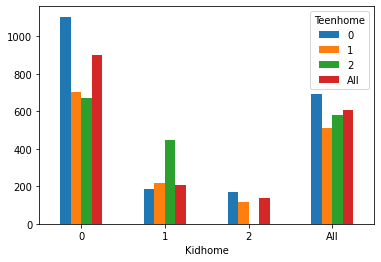

In [ ]:
# this plot is not great, but trying to show which combination of teens and kids home leads to highest total amount spent
table.plot(kind='bar',rot=0)

(0.0, 200000.0)

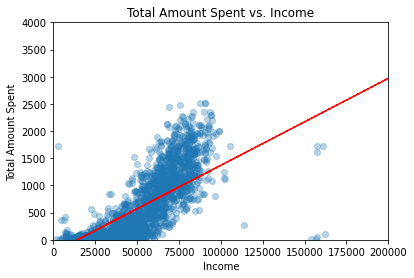

In [ ]:
x = marketing['Income_int']
y = marketing['TotalMntSpent']


z=np.polyfit(x,y,1)
p=np.poly1d(z)
plt.plot(x,p(x),"r--")
plt.scatter(x,y, alpha=0.3)
plt.ylabel('Total Amount Spent')
plt.xlabel('Income')
plt.title('Total Amount Spent vs. Income')
plt.ylim(0,4000)
plt.xlim(0,200000)

# these two variables show a positive correlation, as income increases, the total amount spent also increases

In [ ]:
# which countries have the longest customers vs. most recent
table = marketing.pivot_table(values='DaysSinceJoined', index='Country', aggfunc='mean').sort_values(by='DaysSinceJoined', ascending=False)
table

,DaysSinceJoined
Country,
ME,495.333333
AUS,362.795918
SP,359.662397
GER,355.206897
US,354.728972
IND,347.965986
CA,340.255639
SA,340.225519


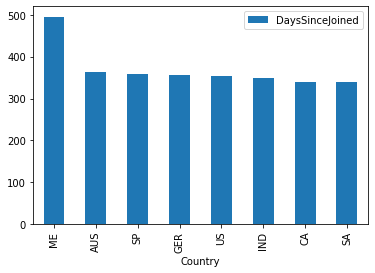

In [ ]:
# average number of days have been customer for by country
table.plot(kind='bar')

In [ ]:
# which countries' customers spent the most money on average
table = marketing.pivot_table(values='TotalMntSpent', index='Country', aggfunc='sum').sort_values(by='TotalMntSpent', ascending=False)
table

,TotalMntSpent
Country,
SP,659557
SA,211071
CA,167403
AUS,85576
IND,77806
GER,73198
US,67546
ME,3122


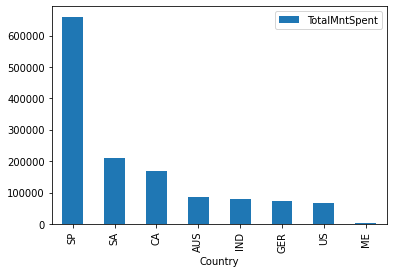

In [ ]:
# average total amount spent per country
table.plot(kind='bar')

In [ ]:
print((marketing[marketing['AcceptedCmp1']==1])['Income_int'].mean(),(marketing[marketing['AcceptedCmp2']==1])['Income_int'].mean(),\
      (marketing[marketing['AcceptedCmp3']==1])['Income_int'].mean(),(marketing[marketing['AcceptedCmp4']==1])['Income_int'].mean(),\
      (marketing[marketing['AcceptedCmp5']==1])['Income_int'].mean())

78872.62676056338 71054.83333333333 50802.58282208589 68663.23170731707 82352.82716049382


In [ ]:
print((marketing[marketing['AcceptedCmp1']==1])['Income_int'].count(),(marketing[marketing['AcceptedCmp2']==1])['Income_int'].count(),\
      (marketing[marketing['AcceptedCmp3']==1])['Income_int'].count(),(marketing[marketing['AcceptedCmp4']==1])['Income_int'].count(),\
      (marketing[marketing['AcceptedCmp5']==1])['Income_int'].count())

142 30 163 164 162


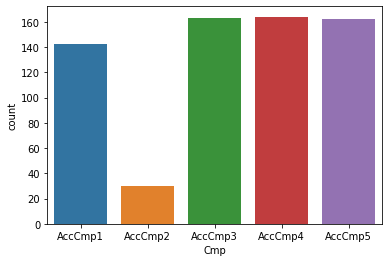

In [ ]:
# number of customers who accepted each campaign
temp_table=pd.DataFrame(data={'Cmp':['AccCmp1','AccCmp2','AccCmp3','AccCmp4','AccCmp5'],'count':[142,30,163,164,162]})
sns.barplot(data=temp_table,y='count',x='Cmp')

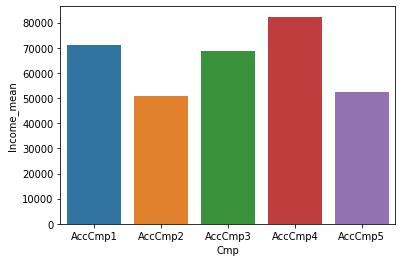

In [ ]:
# average income of customers who accepted each different campaign
temp_table=pd.DataFrame(data={'Cmp':['AccCmp1','AccCmp2','AccCmp3','AccCmp4','AccCmp5'],'Income_mean':[71054,50802,68663,82352,52247]})
sns.barplot(data=temp_table,y='Income_mean',x='Cmp')

In [ ]:
# averages for all variables broken down by customers who accepted each separate campaign
print((marketing[marketing['AcceptedCmp1']==1]).mean(),(marketing[marketing['AcceptedCmp2']==1]).mean(),\
      (marketing[marketing['AcceptedCmp3']==1]).mean(),(marketing[marketing['AcceptedCmp4']==1]).mean(),\
      (marketing[marketing['AcceptedCmp5']==1]).mean())

Kidhome                    0.084507
Teenhome                   0.204225
Recency                   46.683099
MntWines                 758.028169
MntFruits                 55.521127
MntMeatProducts          435.288732
MntFishProducts           92.366197
MntSweetProducts          65.492958
MntGoldProds              77.647887
NumDealsPurchases          1.387324
NumWebPurchases            5.753521
NumCatalogPurchases        6.126761
NumStorePurchases          8.021127
NumWebVisitsMonth          3.514085
AcceptedCmp3               0.169014
AcceptedCmp4               0.316901
AcceptedCmp5               0.478873
AcceptedCmp1               1.000000
AcceptedCmp2               0.091549
Complain                   0.000000
TotalMntSpent           1484.345070
Income_int             78872.626761
DaysSinceJoined          322.690141
Age                       46.619718
dtype: float64 Kidhome                    0.066667
Teenhome                   0.433333
Recency                   48.666667
MntWines     

In [ ]:
#mean of cmp1
((marketing[marketing['AcceptedCmp1']==1]).mean()).Age

46.61971830985915

In [ ]:
#table for mean of each featrure group by cmp
sum_accpted_cmp=pd.concat([(marketing[marketing['AcceptedCmp1']==1]).mean(),(marketing[marketing['AcceptedCmp2']==1]).mean()\
                           ,(marketing[marketing['AcceptedCmp3']==1]).mean(),(marketing[marketing['AcceptedCmp2']==1]).mean()\
                           ,(marketing[marketing['AcceptedCmp2']==1]).mean()],axis=1)

In [ ]:
sum_accpted_cmp.columns = ['AcceptedCmp1', 'AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5']

sum_accpted_cmp_scale=sum_accpted_cmp

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sum_accpted_cmp_scale[['AcceptedCmp1', 'AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5']]= sc.fit_transform(sum_accpted_cmp_scale[['AcceptedCmp1', 'AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5']])


#as the Income_int and TotalMntSpent is much larger than other feature so we drop it for heat map
sum_accpted_cmp_scale=sum_accpted_cmp
sum_accpted_cmp_scale=sum_accpted_cmp_scale.drop(['Income_int','AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','TotalMntSpent'])
sc = StandardScaler()
sum_accpted_cmp_scale[['AcceptedCmp1', 'AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5']]= sc.fit_transform(sum_accpted_cmp_scale[['AcceptedCmp1', 'AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5']])



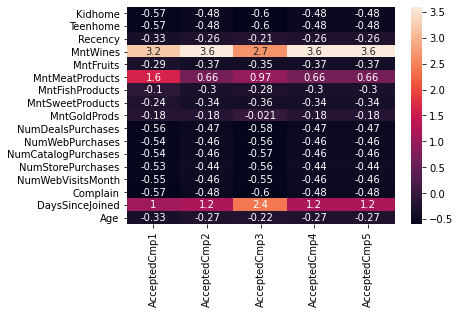

In [ ]:
# heatmap comparing correlation between all variables and each campaign type
sns.heatmap(sum_accpted_cmp_scale, annot = True, cbar = True)

In [ ]:
marketing[marketing["NumStorePurchases"]>marketing["NumWebPurchases"]]["TotalMntSpent"].mean()

595.3210355987055

In [ ]:
marketing[marketing["NumStorePurchases"]<marketing["NumWebPurchases"]]["TotalMntSpent"].mean()

731.8288043478261

<BarContainer object of 2 artists>

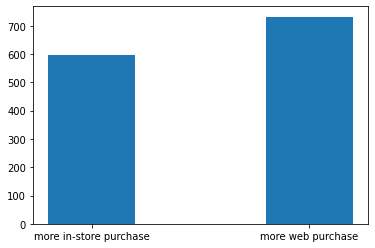

In [ ]:
# want to see which purchase way spends more
# The customers who are more likely use online purchase spend more
x=["more in-store purchase","more web purchase"]
y=[marketing[marketing["NumStorePurchases"]>marketing["NumWebPurchases"]]["TotalMntSpent"].mean(),marketing[marketing["NumStorePurchases"]<marketing["NumWebPurchases"]]["TotalMntSpent"].mean()]
plt.bar(x, y,width = 0.4) 

#Cluster Analysis

### Hierarchical Clustering

In [ ]:
#drop country tage which does not provide a lot information
marketing2 = marketing.drop('Country', axis=1)

In [ ]:
marketing2.head()

,Education,Marital_Status,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,TotalMntSpent,Income_int,DaysSinceJoined,Age
0,Graduation,Divorced,0,0,0,189,104,379,111,189,218,1,4,4,6,1,0,0,0,0,0,0,1190,84835,13,45
1,Graduation,Single,0,0,0,464,5,64,7,0,37,1,7,3,7,5,0,0,0,0,1,0,577,57091,14,54
2,Graduation,Married,0,1,0,134,11,59,15,2,30,1,3,2,5,2,0,0,0,0,0,0,251,67267,47,57
3,Graduation,Together,1,1,0,10,0,1,0,0,0,1,1,0,2,7,0,0,0,0,0,0,11,32474,49,48
4,Graduation,Single,1,0,0,6,16,24,11,0,34,2,3,1,2,7,1,0,0,0,0,0,91,21474,82,26


In [ ]:
marketing2.columns

Index(['Education', 'Marital_Status', 'Kidhome', 'Teenhome', 'Recency',
       'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
       'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
       'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'TotalMntSpent',
       'Income_int', 'DaysSinceJoined', 'Age'],
      dtype='object')

In [ ]:
# splitting data up between numerical and categorical

num_COLS = ['Kidhome', 'Teenhome', 'Recency',
       'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
       'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'TotalMntSpent',
       'Income_int', 'DaysSinceJoined', 'Age']

marketing_n = marketing2.loc[:, num_COLS]
marketing_c = marketing2.drop(columns=num_COLS)

In [ ]:
#normalize the dataset
sc = StandardScaler()
marketing_n_scaled = sc.fit_transform(marketing_n)
marketing_n_scaled = pd.DataFrame(marketing_n_scaled, columns=marketing_n.columns, index=marketing_n.index)

In [ ]:
marketing_n_scaled

,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,TotalMntSpent,Income_int,DaysSinceJoined,Age
0,-0.823039,-0.928972,-1.693488,-0.344228,1.951592,0.945465,1.340203,3.944475,3.359503,-0.688176,-0.031124,0.454182,0.061232,-1.781187,0.967085,1.294840,-1.682509,-0.098441
1,-0.823039,-0.928972,-1.693488,0.471186,-0.536787,-0.459326,-0.559697,-0.658233,-0.134455,-0.688176,1.063634,0.112428,0.368919,-0.131574,-0.049896,0.192461,-1.677568,0.652633
2,-0.823039,0.909066,-1.693488,-0.507311,-0.385976,-0.481624,-0.413550,-0.609527,-0.269580,-0.688176,-0.396043,-0.229327,-0.246455,-1.368784,-0.590737,0.596794,-1.514515,0.902990
3,1.039938,0.909066,-1.693488,-0.874989,-0.662463,-0.740284,-0.687574,-0.658233,-0.848689,-0.688176,-1.125881,-0.912837,-1.169518,0.693232,-0.988903,-0.785669,-1.504633,0.151917
4,1.039938,-0.928972,-1.693488,-0.886850,-0.260301,-0.637712,-0.486623,-0.658233,-0.192366,-0.168231,-0.396043,-0.571082,-1.169518,0.693232,-0.856181,-1.222743,-1.341581,-1.684040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,-0.823039,0.909066,1.727167,0.198393,-0.210030,-0.182828,0.171034,0.510709,0.656994,-0.168231,0.333796,-0.229327,1.599669,-0.543978,0.135915,0.565364,0.619988,-0.599157
2236,1.039938,-0.928972,1.727167,-0.889815,-0.411112,-0.686769,-0.632770,-0.463409,-0.539831,-0.688176,-1.125881,-0.912837,-0.861830,1.105635,-0.915906,-0.842012,0.837391,-0.682609
2237,1.039938,-0.928972,1.727167,-0.356089,-0.612193,-0.352295,-0.413550,-0.536468,-0.578438,-0.168231,0.698715,-0.571082,-0.246455,1.105635,-0.494514,-0.235910,1.084440,-0.599157
2238,-0.823039,-0.928972,1.727167,-0.112947,0.292672,2.381473,2.034398,3.360005,0.367440,-0.688176,0.333796,0.454182,1.291982,-0.956381,1.287277,0.539259,1.104204,-0.766062


In [ ]:
# euclidean distance for numerical data
marketing_e = pdist(marketing_n_scaled.values)

In [ ]:
# categorical data
# one hot encode the data
marketing_cc = marketing_c.astype('category')
marketing_cd = pd.get_dummies(marketing_cc, drop_first=True)

In [ ]:
marketing_cd

,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO,AcceptedCmp3_1,AcceptedCmp4_1,AcceptedCmp5_1,AcceptedCmp1_1,AcceptedCmp2_1,Complain_1
0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
2236,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2237,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2238,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
# use jaccard distance for categorical data

marketing_j = pdist(marketing_cd.values, metric='jaccard')

In [ ]:
marketing_j.shape

(2454220,)

In [ ]:
marketing_e.shape

(2454220,)

In [ ]:
# combining the distance matrices

m_dist = marketing_e + marketing_j

In [ ]:
m_dist.shape

(2454220,)

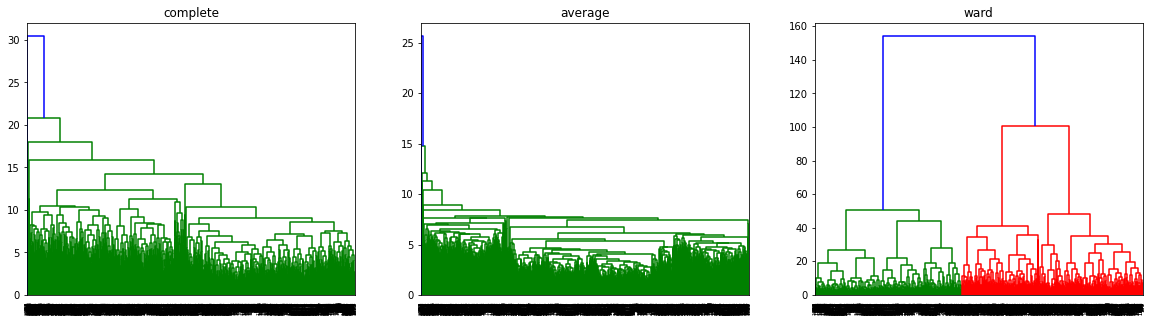

In [ ]:
# FYI this takes like 2 full minutes to run
# single linkage method wouldn't work (dataset is too big to make a dendrogram for it or something?)

METHODS = ['complete', 'average', 'ward']
plt.figure(figsize=(20,5))


# loop and build our plot
for i, m in enumerate(METHODS):
  plt.subplot(1, 3, i+1)
  plt.title(m)
  dendrogram(linkage(m_dist, method=m), 
             leaf_rotation=90)
  
plt.show()

In [ ]:
# ward method splits up the data into the most well-defined groups, so it may be best to use that for hierarchical clustering

m_hclust = linkage(m_dist, method='ward')

In [ ]:
# more than 5 clusters is probably too many if you're looking to use this for customer segmentation, so 3 clusters seems most reasonable when looking at the ward method dendrogram
labels = fcluster(m_hclust, 3, criterion="maxclust")
#labels = fcluster(m_hclust,60, criterion="distance")
marketing2['hcluster label'] = labels
marketing2.head(20)

,Education,Marital_Status,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,TotalMntSpent,Income_int,DaysSinceJoined,Age,hcluster label
0,Graduation,Divorced,0,0,0,189,104,379,111,189,218,1,4,4,6,1,0,0,0,0,0,0,1190,84835,13,45,2
1,Graduation,Single,0,0,0,464,5,64,7,0,37,1,7,3,7,5,0,0,0,0,1,0,577,57091,14,54,3
2,Graduation,Married,0,1,0,134,11,59,15,2,30,1,3,2,5,2,0,0,0,0,0,0,251,67267,47,57,3
3,Graduation,Together,1,1,0,10,0,1,0,0,0,1,1,0,2,7,0,0,0,0,0,0,11,32474,49,48,1
4,Graduation,Single,1,0,0,6,16,24,11,0,34,2,3,1,2,7,1,0,0,0,0,0,91,21474,82,26,1
5,PhD,Single,0,0,0,336,130,411,240,32,43,1,4,7,5,2,0,0,0,0,0,0,1192,71691,104,57,2
6,2n Cycle,Married,0,0,0,769,80,252,15,34,65,1,10,10,7,6,1,0,0,0,0,0,1215,63564,151,61,3
7,Graduation,Together,0,1,0,78,0,11,0,0,7,1,2,1,3,5,0,0,0,0,0,0,96,44931,162,48,1
8,PhD,Married,0,1,0,384,0,102,21,32,5,3,6,2,9,4,0,0,0,0,0,0,544,65324,169,61,3
9,PhD,Married,0,1,0,384,0,102,21,32,5,3,6,2,9,4,0,0,0,0,0,0,544,65324,169,61,3


In [ ]:
# number of customers in each cluster

marketing2['hcluster label'].value_counts(dropna=False, sort=False)

2    517
1    996
3    703
Name: hcluster label, dtype: int64

In [ ]:
# profiles for each customer segment

profile = marketing2.groupby("hcluster label").mean()

profile.T

hcluster label,1,2,3
Kidhome,0.775100,0.023211,0.277383
Teenhome,0.426707,0.170213,0.863442
Recency,50.204819,49.793037,46.749644
MntWines,43.491968,597.038685,461.018492
MntFruits,5.356426,72.375242,22.264580
MntMeatProducts,25.294177,475.365571,140.975818
MntFishProducts,7.176707,101.255319,34.008535
MntSweetProducts,5.343373,74.452611,22.876245
MntGoldProds,15.278112,80.323017,57.870555
NumDealsPurchases,1.928715,1.392650,3.567568


Text(0.5, 1.0, 'Heatmap of Correlations between each Cluster and the Variables')

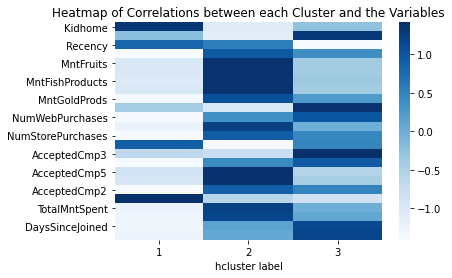

In [ ]:
# heatmap showing correlations between each cluster and all the variables

scp = StandardScaler()
cluster_scaled = scp.fit_transform(profile)

cluster_scaled = pd.DataFrame(cluster_scaled, 
                              index=profile.index, 
                              columns=profile.columns)
cluster_scaled_tran=pd.DataFrame.transpose(cluster_scaled)
g = sns.heatmap(cluster_scaled_tran, cmap="Blues", center=0)
g.set_title('Heatmap of Correlations between each Cluster and the Variables')

### PCA

In [ ]:
# combine the scaled numerical data and catagorical data
marketing3 = pd.concat([marketing_n_scaled,marketing_c], axis=1)

In [ ]:
marketing3.head()

,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,TotalMntSpent,Income_int,DaysSinceJoined,Age,Education,Marital_Status,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain
0,-0.823039,-0.928972,-1.693488,-0.344228,1.951592,0.945465,1.340203,3.944475,3.359503,-0.688176,-0.031124,0.454182,0.061232,-1.781187,0.967085,1.294840,-1.682509,-0.098441,Graduation,Divorced,0,0,0,0,0,0
1,-0.823039,-0.928972,-1.693488,0.471186,-0.536787,-0.459326,-0.559697,-0.658233,-0.134455,-0.688176,1.063634,0.112428,0.368919,-0.131574,-0.049896,0.192461,-1.677568,0.652633,Graduation,Single,0,0,0,0,1,0
2,-0.823039,0.909066,-1.693488,-0.507311,-0.385976,-0.481624,-0.413550,-0.609527,-0.269580,-0.688176,-0.396043,-0.229327,-0.246455,-1.368784,-0.590737,0.596794,-1.514515,0.902990,Graduation,Married,0,0,0,0,0,0
3,1.039938,0.909066,-1.693488,-0.874989,-0.662463,-0.740284,-0.687574,-0.658233,-0.848689,-0.688176,-1.125881,-0.912837,-1.169518,0.693232,-0.988903,-0.785669,-1.504633,0.151917,Graduation,Together,0,0,0,0,0,0
4,1.039938,-0.928972,-1.693488,-0.886850,-0.260301,-0.637712,-0.486623,-0.658233,-0.192366,-0.168231,-0.396043,-0.571082,-1.169518,0.693232,-0.856181,-1.222743,-1.341581,-1.684040,Graduation,Single,1,0,0,0,0,0


In [ ]:
# one hot encode
marketing3 = pd.get_dummies(marketing3,columns=['Education', 'Marital_Status'],drop_first=True)

In [ ]:
marketing3.head()

,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,TotalMntSpent,Income_int,DaysSinceJoined,Age,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO
0,-0.823039,-0.928972,-1.693488,-0.344228,1.951592,0.945465,1.340203,3.944475,3.359503,-0.688176,-0.031124,0.454182,0.061232,-1.781187,0.967085,1.294840,-1.682509,-0.098441,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
1,-0.823039,-0.928972,-1.693488,0.471186,-0.536787,-0.459326,-0.559697,-0.658233,-0.134455,-0.688176,1.063634,0.112428,0.368919,-0.131574,-0.049896,0.192461,-1.677568,0.652633,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0
2,-0.823039,0.909066,-1.693488,-0.507311,-0.385976,-0.481624,-0.413550,-0.609527,-0.269580,-0.688176,-0.396043,-0.229327,-0.246455,-1.368784,-0.590737,0.596794,-1.514515,0.902990,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
3,1.039938,0.909066,-1.693488,-0.874989,-0.662463,-0.740284,-0.687574,-0.658233,-0.848689,-0.688176,-1.125881,-0.912837,-1.169518,0.693232,-0.988903,-0.785669,-1.504633,0.151917,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
4,1.039938,-0.928972,-1.693488,-0.886850,-0.260301,-0.637712,-0.486623,-0.658233,-0.192366,-0.168231,-0.396043,-0.571082,-1.169518,0.693232,-0.856181,-1.222743,-1.341581,-1.684040,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0


In [ ]:
pca = PCA()
pcs = pca.fit_transform(marketing3)

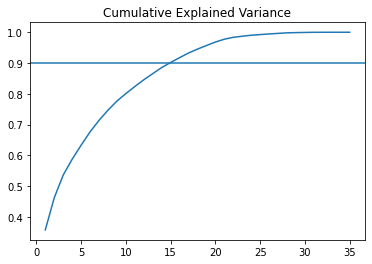

In [ ]:
# it needs 15 features to explian 90% of variance
varexp = pca.explained_variance_ratio_
plt.title("Cumulative Explained Variance")
plt.plot(range(1, len(varexp)+1), np.cumsum(varexp))
plt.axhline(.90)

In [ ]:
#select top 15 pc
comps = pcs[:,:15]

In [ ]:
comps

array([[ 4.30957046, -2.41927634, -0.01004959, ..., -1.33465282,
        -0.96495606, -0.47616545],
       [ 0.16611263, -0.3874954 ,  1.372809  , ..., -0.23583481,
         0.67019427, -0.50769911],
       [-0.51383548, -0.61391101,  2.75316147, ..., -0.13864085,
         0.36677722,  0.60779159],
       ...,
       [-1.54361997,  0.2416542 , -1.59747468, ...,  0.03689698,
         0.78729287, -0.10637285],
       [ 3.99626623, -1.51457987, -1.63311717, ...,  0.24637741,
        -0.46346956,  0.56898837],
       [ 2.60806035,  1.82627433, -0.21483129, ...,  2.71632802,
         0.998716  ,  1.39681382]])

In [ ]:
#create a new dataframe to include the pca features
pca_df = pd.DataFrame(comps,columns=["pc1","pc2","pc3","pc4","pc5","pc6","pc7","pc8","pc9","pc10","pc11","pc12","pc13","pc14","pc15"])

###K-Means Clustering

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


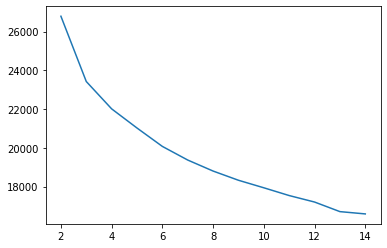

In [ ]:
# plotting inertia values 

ss = []
K = range(2,15)
for k in K:
    km = KMeans(n_clusters=k)
    km.fit(pca_df)
    ss.append(km.inertia_)
sns.lineplot(K, ss)
plt.plot([5], [0:], linewidth=2)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


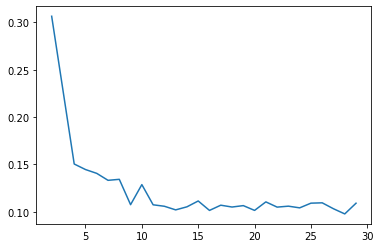

In [ ]:
# plotting silhouette score

KRANGE = range(2, 30)

ss = []


for k in KRANGE:
  km = KMeans(k)
  lab = km.fit_predict(pca_df)
  ss.append(metrics.silhouette_score(pca_df, lab))

sns.lineplot(KRANGE, ss)

In [ ]:
# set seed to hold the result consistently
import random
random.seed(42)

In [ ]:

# fit the model
# choosing 4 clusters for kmeans based on inertia and silhouette scores
k4 = KMeans(4,n_init=100)
k4.fit(pca_df)
k4_labs = k4.predict(pca_df)

In [ ]:
# put the cluset back to the original data
marketing4 = marketing2.copy()
marketing4["kmeans cluster"] = k4_labs


In [ ]:
marketing4.head()

,Education,Marital_Status,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,TotalMntSpent,Income_int,DaysSinceJoined,Age,kmeans cluster
0,Graduation,Divorced,0,0,0,189,104,379,111,189,218,1,4,4,6,1,0,0,0,0,0,0,1190,84835,13,45,0
1,Graduation,Single,0,0,0,464,5,64,7,0,37,1,7,3,7,5,0,0,0,0,1,0,577,57091,14,54,2
2,Graduation,Married,0,1,0,134,11,59,15,2,30,1,3,2,5,2,0,0,0,0,0,0,251,67267,47,57,1
3,Graduation,Together,1,1,0,10,0,1,0,0,0,1,1,0,2,7,0,0,0,0,0,0,11,32474,49,48,1
4,Graduation,Single,1,0,0,6,16,24,11,0,34,2,3,1,2,7,1,0,0,0,0,0,91,21474,82,26,3


In [ ]:
marketing4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2216 entries, 0 to 2239
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Education            2216 non-null   object
 1   Marital_Status       2216 non-null   object
 2   Kidhome              2216 non-null   int64 
 3   Teenhome             2216 non-null   int64 
 4   Recency              2216 non-null   int64 
 5   MntWines             2216 non-null   int64 
 6   MntFruits            2216 non-null   int64 
 7   MntMeatProducts      2216 non-null   int64 
 8   MntFishProducts      2216 non-null   int64 
 9   MntSweetProducts     2216 non-null   int64 
 10  MntGoldProds         2216 non-null   int64 
 11  NumDealsPurchases    2216 non-null   int64 
 12  NumWebPurchases      2216 non-null   int64 
 13  NumCatalogPurchases  2216 non-null   int64 
 14  NumStorePurchases    2216 non-null   int64 
 15  NumWebVisitsMonth    2216 non-null   int64 
 16  Accept

In [ ]:
marketing4['kmeans cluster'].value_counts()

1    560
3    558
0    552
2    546
Name: kmeans cluster, dtype: int64

In [ ]:
group_stat = marketing4.groupby("kmeans cluster").mean()
group_stat.head()

,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,TotalMntSpent,Income_int,DaysSinceJoined,Age
kmeans cluster,,,,,,,,,,,,,,,,,,,,,,,,
0,0.036232,0.148551,49.849638,612.536232,68.952899,464.625000,100.442029,71.387681,77.164855,1.253623,5.050725,6.101449,8.394928,2.722826,0.081522,0.117754,0.260870,0.210145,0.028986,0.005435,1395.108696,77628.579710,352.701087,46.621377
1,0.660714,0.957143,50.300000,74.255357,5.048214,27.550000,6.705357,4.846429,15.160714,2.425000,2.392857,0.775000,3.700000,5.773214,0.046429,0.032143,0.000000,0.007143,0.003571,0.010714,133.566071,43112.717857,298.458929,51.796429
2,0.199634,0.904762,47.507326,508.355311,25.765568,152.741758,34.595238,26.053114,67.078755,3.732601,6.723443,3.344322,8.084249,5.767399,0.075092,0.144689,0.032967,0.038462,0.021978,0.009158,814.589744,59259.254579,420.826007,49.857143
3,0.860215,0.014337,48.365591,33.724014,6.179211,26.460573,9.528674,6.363799,17.413978,1.901434,2.247312,0.521505,3.109319,6.992832,0.091398,0.003584,0.000000,0.001792,0.000000,0.012545,99.670251,29444.906810,343.734767,36.507168


In [ ]:
# profiles for each customer segment

profile = marketing4.groupby("kmeans cluster").mean()

profile.T

kmeans cluster,0,1,2,3
Kidhome,0.036232,0.660714,0.199634,0.860215
Teenhome,0.148551,0.957143,0.904762,0.014337
Recency,49.849638,50.300000,47.507326,48.365591
MntWines,612.536232,74.255357,508.355311,33.724014
MntFruits,68.952899,5.048214,25.765568,6.179211
MntMeatProducts,464.625000,27.550000,152.741758,26.460573
MntFishProducts,100.442029,6.705357,34.595238,9.528674
MntSweetProducts,71.387681,4.846429,26.053114,6.363799
MntGoldProds,77.164855,15.160714,67.078755,17.413978
NumDealsPurchases,1.253623,2.425000,3.732601,1.901434


Text(0.5, 1.0, 'Heatmap of Correlations between each Cluster and the Variables')

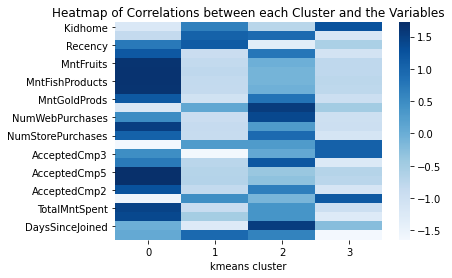

In [ ]:
# heatmap showing correlations between each cluster and all the variables

scp = StandardScaler()
cluster_scaled = scp.fit_transform(profile)
#form dataframe
cluster_scaled = pd.DataFrame(cluster_scaled, 
                              index=profile.index, 
                              columns=profile.columns)
cluster_scaled_tran=pd.DataFrame.transpose(cluster_scaled)
g = sns.heatmap(cluster_scaled_tran, cmap="Blues", center=0)
g.set_title('Heatmap of Correlations between each Cluster and the Variables')

In [ ]:
cluster_scaled.head()

,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,TotalMntSpent,Income_int,DaysSinceJoined,Age
kmeans cluster,,,,,,,,,,,,,,,,,,,,,,,,
0,-1.206659,-0.836020,0.751722,1.191283,1.641877,1.659192,1.658892,1.645970,1.170659,-1.179719,0.503879,1.511258,1.059223,-1.643031,0.472815,0.740510,1.718805,1.708548,1.261447,-1.539519,1.465625,1.403347,-0.028092,0.072286
1,0.663314,1.054108,1.152845,-0.908966,-0.828866,-0.784334,-0.824158,-0.830572,-1.031558,0.106314,-0.910107,-0.845276,-0.873678,0.291132,-1.624377,-0.726598,-0.673719,-0.670979,-0.826815,0.478299,-0.891600,-0.513672,-1.267806,0.950729
2,-0.717362,0.931664,-1.334498,0.784793,-0.027872,-0.084433,-0.085365,-0.041299,0.812428,1.541904,1.393765,0.291446,0.931317,0.287444,0.088544,1.202094,-0.371367,-0.303871,0.685645,-0.116699,0.380910,0.383111,1.528915,0.621544
3,1.260707,-1.149752,-0.570069,-1.067110,-0.785139,-0.790425,-0.749369,-0.774099,-0.951528,-0.468500,-0.987537,-0.957428,-1.116862,1.064456,1.063018,-1.216006,-0.673719,-0.733698,-1.120277,1.177919,-0.954935,-1.272786,-0.233018,-1.644558


Text(0.5, 1.0, 'Heatmap of Correlations between each Cluster and the Variables')

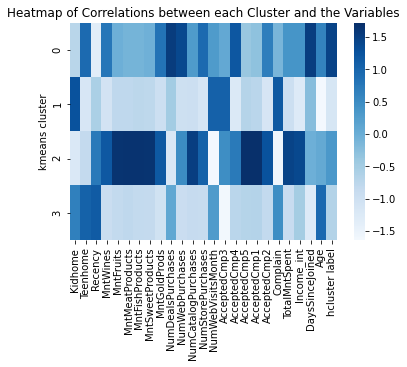

In [ ]:
# the heatmap above that was turned doesn't show all of the variables... so I put this one back
scp = StandardScaler()
cluster_scaled = scp.fit_transform(profile)

cluster_scaled = pd.DataFrame(cluster_scaled, 
                              index=profile.index, 
                              columns=profile.columns)

g = sns.heatmap(cluster_scaled, cmap="Blues", center=0)
g.set_title('Heatmap of Correlations between each Cluster and the Variables')

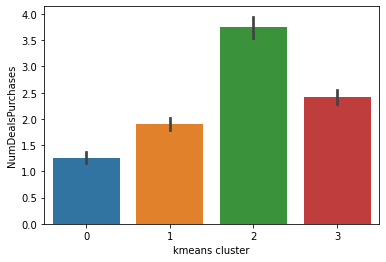

In [ ]:
#deal purchase vs cluster
sns.barplot(data=marketing4,y='NumDealsPurchases',x='kmeans cluster')

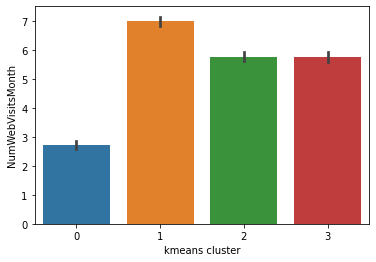

In [ ]:
#web visit vs cluster
sns.barplot(data=marketing4,y='NumWebVisitsMonth',x='kmeans cluster')

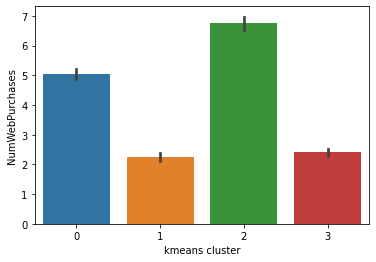

In [ ]:
#web purchase vs cluster
sns.barplot(data=marketing4,y='NumWebPurchases',x='kmeans cluster')

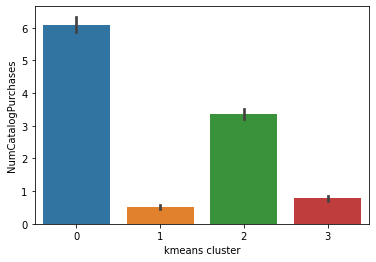

In [ ]:
#catalog purchase vs cluster
sns.barplot(data=marketing4,y='NumCatalogPurchases',x='kmeans cluster')

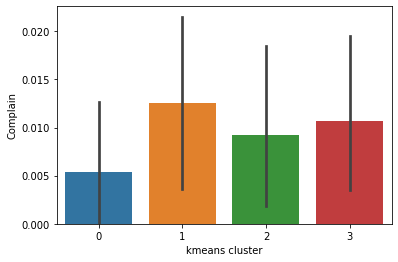

In [ ]:
# group0 has the most complain and spent the least, maybe the mall can send them a survey to know what the mall need to improve
sns.barplot(data=marketing4,y='Complain',x='kmeans cluster')

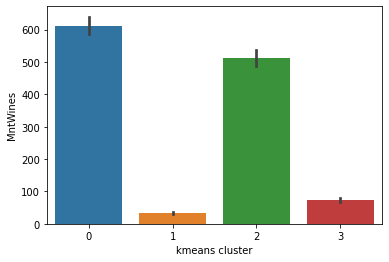

In [ ]:
#wine vs cluster
sns.barplot(data=marketing4,y='MntWines',x='kmeans cluster')

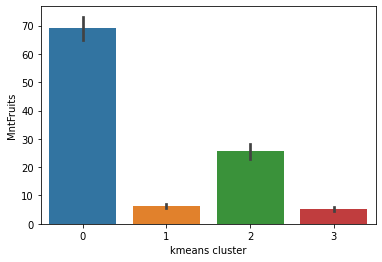

In [ ]:
# group 0 has lagrgest numbers of deal purchases, may give more deals to this group
sns.barplot(data=marketing4,y='MntFruits',x='kmeans cluster')

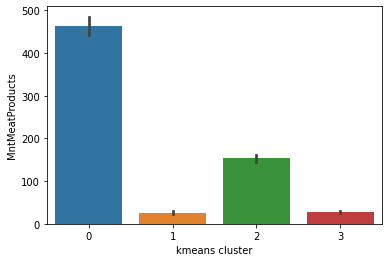

In [ ]:
# group 0 puchased the most Meat on average
sns.barplot(data=marketing4,y='MntMeatProducts',x='kmeans cluster')

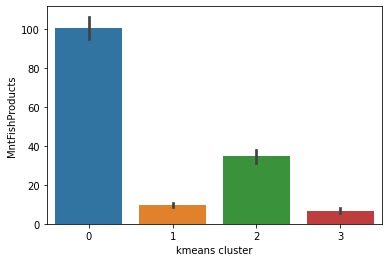

In [ ]:
# group2 puchased the most fish on average
sns.barplot(data=marketing4,y='MntFishProducts',x='kmeans cluster')

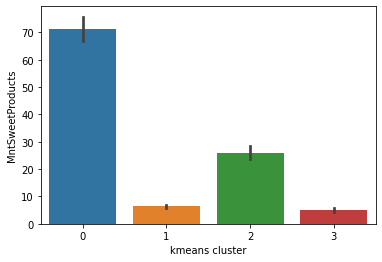

In [ ]:
# group2 puchased the most sweet on average
sns.barplot(data=marketing4,y='MntSweetProducts',x='kmeans cluster')

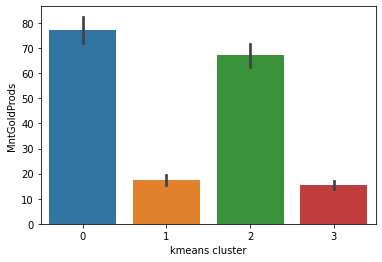

In [ ]:
# group2 puchased the most gold on average
sns.barplot(data=marketing4,y='MntGoldProds',x='kmeans cluster')

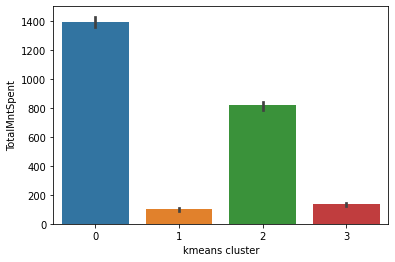

In [ ]:
# Group 0 spent the most total
sns.barplot(data=marketing4,y='TotalMntSpent',x='kmeans cluster')